
From Kaggle: 
"MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike."

[Read more.](https://www.kaggle.com/c/digit-recognizer)


<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

### Pytorch Advantages vs Tensorflow
- Pytorch Enables dynamic computational graphs (which change be changed) while Tensorflow is static. 
- Tensorflow enables easier deployment. 

# Question 1

In [21]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [43]:
%matplotlib inline

In [22]:
#define the training parameters
batch_size=32
test_batch_size=32
epochs=30  #The number of Epochs is the number of times you go through the full dataset. 

seed=1 #random seed
log_interval=10 #log data about statics
cuda=True #use gpu training


In [23]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=test_batch_size, shuffle=True)


In [24]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self , activation='relu'):
        super(Net, self).__init__()
        self.img_size = 28*28
        self.fc1 = nn.Linear(self.img_size,1024)          # fully connected layer 1
        self.fc2 = nn.Linear(1024, 1024)                   # fully connected layer 2
        self.fc3 = nn.Linear(1024,1024 )                     # fully connected layer 3
        self.fc4 = nn.Linear(1024,1024 )                   # fully connected layer 4
        self.fc5 = nn.Linear(1024, 1024 )                    # fully connected layer 5
        self.out_layer = nn.Linear(1024,10)                # output layer
        #select the activation function
        if(activation=='relu'):
            self.activation_fn = nn.ReLU()
        if(activation=='logistic_sigmoid'):
            self.activation_fn = nn.LogSigmoid()

    def forward(self, x):
        #flatten the input vector
        x = x.view(-1, self.img_size)
        #Linear Layer 1 /Activation
        x = self.activation_fn( self.fc1(x) ) 
        #Linear Layer 2 /Activation
        x = self.activation_fn( self.fc2(x) ) 
        #Linear Layer 3 /Activation
        x = self.activation_fn( self.fc3(x) ) 
        #Linear Layer 4 /Activation
        x = self.activation_fn( self.fc4(x) ) 
        #Linear Layer 5 /Activation
        x = self.activation_fn( self.fc5(x) ) 
        
        out = self.out_layer(x)
        #Softmax gets probabilities. 
        return out

#model weight initialization function 
def init_weights_normal(m):
    if type(m) == nn.Linear:
    
        torch.nn.init.normal_(m.weight , mean=0 , std=0.01)
        m.bias.data.fill_(0.01)

def init_weights_xavier(m):
    if type(m) == nn.Linear:      
        torch.nn.init.xavier_normal_(m.weight ,gain=0.5)
        m.bias.data.fill_(0)
def init_weights_kaiman(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

In [25]:
#training the model
def train(epoch , model , optimizer):
    model_test_accuracy = []
    model.train()
    for i_epoch in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
            #Variables in Pytorch are differenciable. 
            data, target = Variable(data), Variable(target)
            #This will zero out the gradients for this batch. 
            optimizer.zero_grad()
            output = model(data)
            # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
            loss = criterion(output, target)
            #dloss/dx for every Variable 
            loss.backward()
            #to do a one-step update on our parameter.
            optimizer.step()
            #Print out the loss periodically. 
            if((i_epoch+1)%30==0):
                if batch_idx % log_interval == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        i_epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.detach().item()))
            

        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                if cuda:
                    data, target = data.cuda(), target.cuda()
                data, target = data, target
                output = model(data)
                test_loss +=criterion(output, target).detach().item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

            test_loss /= len(test_loader.dataset)
            if((i_epoch+1)%30==0):
                print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                    test_loss, correct, len(test_loader.dataset),
                    100. * correct / len(test_loader.dataset)))
        
        model.train()

        model_test_accuracy.append(100. * correct / len(test_loader.dataset))
    return model_test_accuracy

# Model 1 Training

In [26]:
device="cuda:0" if torch.cuda.is_available() else "cpu"

In [27]:
# --------------------------> activation =relu |  init_method=kaiman
model = Net(activation='relu')
model.apply(init_weights_kaiman)
if cuda:
    model.cuda()
optimizer_adam = optim.Adam(model.parameters() , lr=0.0001)
criterion = nn.CrossEntropyLoss()
#Adam Training

model5_ADAM_accuracy  = train(epochs ,model ,  optimizer_adam)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.000068
Train Epoch: 29 [320/60000 (1%)]	Loss: 0.000011
Train Epoch: 29 [640/60000 (1%)]	Loss: 0.000071
Train Epoch: 29 [960/60000 (2%)]	Loss: 0.000001
Train Epoch: 29 [1280/60000 (2%)]	Loss: 0.000438
Train Epoch: 29 [1600/60000 (3%)]	Loss: 0.000930
Train Epoch: 29 [1920/60000 (3%)]	Loss: 0.000012
Train Epoch: 29 [2240/60000 (4%)]	Loss: 0.048179
Train Epoch: 29 [2560/60000 (4%)]	Loss: 0.000197
Train Epoch: 29 [2880/60000 (5%)]	Loss: 0.000110
Train Epoch: 29 [3200/60000 (5%)]	Loss: 0.000029
Train Epoch: 29 [3520/60000 (6%)]	Loss: 0.015260
Train Epoch: 29 [3840/60000 (6%)]	Loss: 0.000061
Train Epoch: 29 [4160/60000 (7%)]	Loss: 0.000259
Train Epoch: 29 [4480/60000 (7%)]	Loss: 0.000122
Train Epoch: 29 [4800/60000 (8%)]	Loss: 0.000048
Train Epoch: 29 [5120/60000 (9%)]	Loss: 0.000108
Train Epoch: 29 [5440/60000 (9%)]	Loss: 0.000090
Train Epoch: 29 [5760/60000 (10%)]	Loss: 0.000000
Train Epoch: 29 [6080/60000 (10%)]	Loss: 0.000709
Train Epoch: 29 [6400/60

Train Epoch: 29 [51840/60000 (86%)]	Loss: 0.001015
Train Epoch: 29 [52160/60000 (87%)]	Loss: 0.000062
Train Epoch: 29 [52480/60000 (87%)]	Loss: 0.019131
Train Epoch: 29 [52800/60000 (88%)]	Loss: 0.001034
Train Epoch: 29 [53120/60000 (89%)]	Loss: 0.000005
Train Epoch: 29 [53440/60000 (89%)]	Loss: 0.000261
Train Epoch: 29 [53760/60000 (90%)]	Loss: 0.000196
Train Epoch: 29 [54080/60000 (90%)]	Loss: 0.000698
Train Epoch: 29 [54400/60000 (91%)]	Loss: 0.000031
Train Epoch: 29 [54720/60000 (91%)]	Loss: 0.155675
Train Epoch: 29 [55040/60000 (92%)]	Loss: 0.000348
Train Epoch: 29 [55360/60000 (92%)]	Loss: 0.000041
Train Epoch: 29 [55680/60000 (93%)]	Loss: 0.282977
Train Epoch: 29 [56000/60000 (93%)]	Loss: 0.190254
Train Epoch: 29 [56320/60000 (94%)]	Loss: 0.000033
Train Epoch: 29 [56640/60000 (94%)]	Loss: 0.000066
Train Epoch: 29 [56960/60000 (95%)]	Loss: 0.014275
Train Epoch: 29 [57280/60000 (95%)]	Loss: 0.074085
Train Epoch: 29 [57600/60000 (96%)]	Loss: 0.000045
Train Epoch: 29 [57920/60000 (9

In [28]:
import numpy as np

D_list = [10, 20, 50, 100, 200 , "all"]
layers_list = np.copy(list(model.children()))

final_svd_output = []

for i_d in D_list :

    svd_info = []
    for i_layer in layers_list[:-2] :
        if type(i_layer) == nn.Linear:      
            u, s, v = torch.svd(i_layer.weight)
            svd_info.append([u,s,v])
            
    model_svd = Net(activation='relu')
    model_svd.apply(init_weights_kaiman)
    if cuda:
        model_svd.cuda()
            
    svd_layers = list(model_svd.children()).copy()
    
    for i , i_layer in enumerate(svd_layers[:-1] ):
        if type(i_layer) == nn.Linear:   
            if(i!=5):

                u, s, v = svd_info[i]

                if(i_d !="all"):
                    s = s[:i_d]
                    u = u[:,:i_d]
                    v = v[:,:i_d]
                
                i_layer.weight.data = torch.mm(torch.mm(u, torch.diag(s)), v.t())

            if(i==5):
                i_layer.weight.data = layers_list[i].weight.data
                i_layer.bias.data = layers_list[i].bias.data
            
    final_svd_output.append(np.copy(svd_layers))

In [29]:
class SVD_Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self , layer_list ,  activation='relu'):
        super(SVD_Net, self).__init__()
        self.img_size = 28*28
        self.fc1 = layer_list[0]          # fully connected layer 1
        self.fc2 = layer_list[1]          # fully connected layer 2 
        self.fc3 = layer_list[2]          # fully connected layer 3
        self.fc4 = layer_list[3]          # fully connected layer 4
        self.fc5 = layer_list[4]          # fully connected layer 5
        self.out_layer = layer_list[5]    # output layer
        #select the activation function
        if(activation=='relu'):
            self.activation_fn = nn.ReLU()
        if(activation=='logistic_sigmoid'):
            self.activation_fn = nn.LogSigmoid()

    def forward(self, x):
        #flatten the input vector
        x = x.view(-1, self.img_size)
        #Linear Layer 1 /Activation
        x = self.activation_fn( self.fc1(x) ) 
        #Linear Layer 2 /Activation
        x = self.activation_fn( self.fc2(x) ) 
        #Linear Layer 3 /Activation
        x = self.activation_fn( self.fc3(x) ) 
        #Linear Layer 4 /Activation
        x = self.activation_fn( self.fc4(x) ) 
        #Linear Layer 5 /Activation
        x = self.activation_fn( self.fc5(x) ) 
        
        out = self.out_layer(x)
        #Softmax gets probabilities. 
        return out

In [30]:
def test_svd(my_model):
    my_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = data, target
            output = my_model(data)
            test_loss +=criterion(output, target).detach().item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

            test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [31]:
test_accuracy =[]
for i_svd_layer in final_svd_output:

    my_model = SVD_Net(i_svd_layer)
    i_acc = test_svd(my_model)
    test_accuracy.append(i_acc)


Test set: Average loss: 0.0001, Accuracy: 4662/10000 (47%)


Test set: Average loss: 0.0002, Accuracy: 8861/10000 (89%)


Test set: Average loss: 0.0000, Accuracy: 9678/10000 (97%)


Test set: Average loss: 0.0000, Accuracy: 9736/10000 (97%)


Test set: Average loss: 0.0000, Accuracy: 9769/10000 (98%)


Test set: Average loss: 0.0000, Accuracy: 9805/10000 (98%)



(-0.5, 100.0)

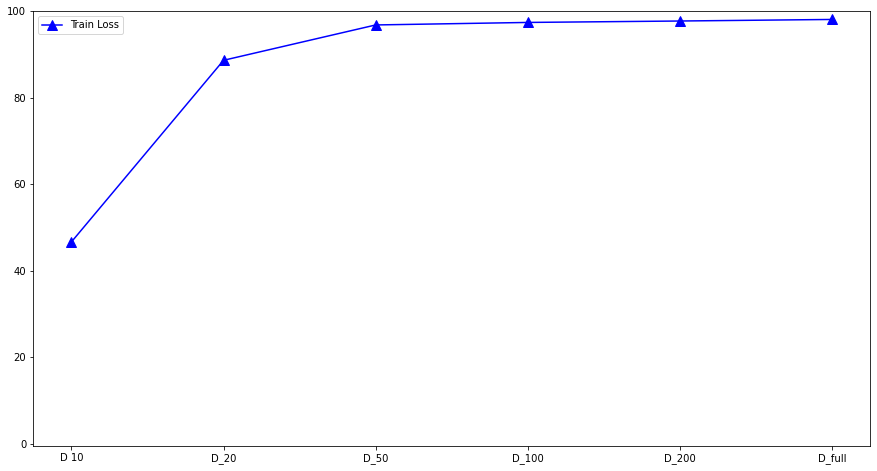

In [44]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,8))

plt.plot(test_accuracy, "-^b", markersize= 10, label="Train Loss")
plt.xticks(np.arange(6), ["D 10", "D_20", "D_50", "D_100", "D_200" , "D_full"] ) 
plt.legend(loc="upper left")
plt.ylim(-0.5, 100.0)

# Question 2

In [33]:
class SVD_Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self , layer_list ,  activation='relu'):
        super(SVD_Net, self).__init__()
        self.img_size = 28*28
        self.fc1 = layer_list[0]          # fully connected layer 1
        self.fc2 = layer_list[1]          # fully connected layer 2 
        self.fc3 = layer_list[2]          # fully connected layer 3
        self.fc4 = layer_list[3]          # fully connected layer 4
        self.fc5 = layer_list[4]          # fully connected layer 5
        self.out_layer = layer_list[5]    # output layer
        #select the activation function
        if(activation=='relu'):
            self.activation_fn = nn.ReLU()
        if(activation=='logistic_sigmoid'):
            self.activation_fn = nn.LogSigmoid()

    def forward(self, x):
        #flatten the input vector
        x = x.view(-1, self.img_size)
        #Linear Layer 1 /Activation
        x = self.activation_fn( self.fc1(x) ) 
        #Linear Layer 2 /Activation
        x = self.activation_fn( self.fc2(x) ) 
        #Linear Layer 3 /Activation
        x = self.activation_fn( self.fc3(x) ) 
        #Linear Layer 4 /Activation
        x = self.activation_fn( self.fc4(x) ) 
        #Linear Layer 5 /Activation
        x = self.activation_fn( self.fc5(x) ) 
        
        out = self.out_layer(x)
        #Softmax gets probabilities. 
        return out

In [34]:
svd_model = SVD_Net(final_svd_output[1])
i_acc = test_svd(svd_model)


Test set: Average loss: 0.0001, Accuracy: 8861/10000 (89%)



# FineTune the model

In [35]:
# --------------------------> activation =relu |  init_method=kaiman
if cuda:
    svd_model.cuda()
optimizer_adam = optim.Adam(svd_model.parameters() , lr=0.00001)
criterion = nn.CrossEntropyLoss()
#Adam Training

model5_ADAM_accuracy  = train(epochs , svd_model ,  optimizer_adam)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.000002
Train Epoch: 29 [320/60000 (1%)]	Loss: 0.000000
Train Epoch: 29 [640/60000 (1%)]	Loss: 0.000000
Train Epoch: 29 [960/60000 (2%)]	Loss: 0.000615
Train Epoch: 29 [1280/60000 (2%)]	Loss: 0.001153
Train Epoch: 29 [1600/60000 (3%)]	Loss: 0.000078
Train Epoch: 29 [1920/60000 (3%)]	Loss: 0.000000
Train Epoch: 29 [2240/60000 (4%)]	Loss: 0.000009
Train Epoch: 29 [2560/60000 (4%)]	Loss: 0.000000
Train Epoch: 29 [2880/60000 (5%)]	Loss: 0.000241
Train Epoch: 29 [3200/60000 (5%)]	Loss: 0.000002
Train Epoch: 29 [3520/60000 (6%)]	Loss: 0.000001
Train Epoch: 29 [3840/60000 (6%)]	Loss: 0.000009
Train Epoch: 29 [4160/60000 (7%)]	Loss: 0.000000
Train Epoch: 29 [4480/60000 (7%)]	Loss: 0.000002
Train Epoch: 29 [4800/60000 (8%)]	Loss: 0.000044
Train Epoch: 29 [5120/60000 (9%)]	Loss: 0.000003
Train Epoch: 29 [5440/60000 (9%)]	Loss: 0.000002
Train Epoch: 29 [5760/60000 (10%)]	Loss: 0.000000
Train Epoch: 29 [6080/60000 (10%)]	Loss: 0.000074
Train Epoch: 29 [6400/60

Train Epoch: 29 [51840/60000 (86%)]	Loss: 0.000008
Train Epoch: 29 [52160/60000 (87%)]	Loss: 0.000000
Train Epoch: 29 [52480/60000 (87%)]	Loss: 0.000056
Train Epoch: 29 [52800/60000 (88%)]	Loss: 0.000001
Train Epoch: 29 [53120/60000 (89%)]	Loss: 0.000008
Train Epoch: 29 [53440/60000 (89%)]	Loss: 0.000002
Train Epoch: 29 [53760/60000 (90%)]	Loss: 0.000000
Train Epoch: 29 [54080/60000 (90%)]	Loss: 0.000000
Train Epoch: 29 [54400/60000 (91%)]	Loss: 0.000000
Train Epoch: 29 [54720/60000 (91%)]	Loss: 0.000000
Train Epoch: 29 [55040/60000 (92%)]	Loss: 0.000018
Train Epoch: 29 [55360/60000 (92%)]	Loss: 0.000281
Train Epoch: 29 [55680/60000 (93%)]	Loss: 0.000000
Train Epoch: 29 [56000/60000 (93%)]	Loss: 0.000001
Train Epoch: 29 [56320/60000 (94%)]	Loss: 0.000000
Train Epoch: 29 [56640/60000 (94%)]	Loss: 0.000050
Train Epoch: 29 [56960/60000 (95%)]	Loss: 0.000000
Train Epoch: 29 [57280/60000 (95%)]	Loss: 0.000000
Train Epoch: 29 [57600/60000 (96%)]	Loss: 0.000000
Train Epoch: 29 [57920/60000 (9

# Question 3

In [36]:
import torch

class svd_ffmodel(nn.Module):
    #This defines the structure of the NN.
    def __init__(self , layer_list ,  activation='relu'):
        super(svd_ffmodel, self).__init__()
        self.img_size = 28*28
        self.fc1 = layer_list[0]          # fully connected layer 1
        self.fc2 = layer_list[1]          # fully connected layer 2 
        self.fc3 = layer_list[2]          # fully connected layer 3
        self.fc4 = layer_list[3]          # fully connected layer 4
        self.fc5 = layer_list[4]          # fully connected layer 5
        self.out_layer = layer_list[5]    # output layer
        #select the activation function
        if(activation=='relu'):
            self.activation_fn = nn.ReLU()
        if(activation=='logistic_sigmoid'):
            self.activation_fn = nn.LogSigmoid()

    def forward(self, x):
        #flatten the input vector
        x = x.view(-1, self.img_size)
        
        #Linear Layer 1 /Activation
        u, s, v = torch.svd(self.fc1.weight)
        x = x.mm(torch.mm(torch.mm(u[:,:20], torch.diag(s[:20])), v[:,:20].t()))
        x = self.activation_fn( x ) 
        
        #Linear Layer 2 /Activation
        u, s, v = torch.svd(self.fc2.weight)
        x = x.mm(torch.mm(torch.mm(u[:,:20], torch.diag(s[:20])), v[:,:20].t()))
        x = self.activation_fn(x) 
        
        #Linear Layer 3 /Activation
        u, s, v = torch.svd(self.fc3.weight)
        x = x.mm(torch.mm(torch.mm(u[:,:20], torch.diag(s[:20])), v[:,:20].t()))
        x = self.activation_fn(x)
        
        #Linear Layer 4 /Activation
        u, s, v = torch.svd(self.fc4.weight)
        x = x.mm(torch.mm(torch.mm(u[:,:20], torch.diag(s[:20])), v[:,:20].t()))
        x = self.activation_fn(x)
        #Linear Layer 5 /Activation
        u, s, v = torch.svd(self.fc5.weight)
        x = x.mm(torch.mm(torch.mm(u[:,:20], torch.diag(s[:20])), v[:,:20].t()))
        x = self.activation_fn(x)
        
        out = self.out_layer(x)
        #Softmax gets probabilities. 
        return out

In [38]:
model_base = Net(activation='relu')
model_base.apply(init_weights_kaiman)
if cuda:
    model_base.cuda()
            
base_layers = list(model_base.children())

In [40]:
svd_model = SVD_Net( base_layers )

In [41]:
learning_rate = 1e-4

# --------------------------> activation =relu |  init_method=kaiman
if cuda:
    svd_model.cuda()
optimizer_adam = optim.Adam(svd_model.parameters() , lr=0.00001)
criterion = nn.CrossEntropyLoss()
#Adam Training

model5_ADAM_accuracy  = train(epochs , svd_model ,  optimizer_adam)

Train Epoch: 29 [0/60000 (0%)]	Loss: 0.000017
Train Epoch: 29 [320/60000 (1%)]	Loss: 0.000008
Train Epoch: 29 [640/60000 (1%)]	Loss: 0.000212
Train Epoch: 29 [960/60000 (2%)]	Loss: 0.000257
Train Epoch: 29 [1280/60000 (2%)]	Loss: 0.000219
Train Epoch: 29 [1600/60000 (3%)]	Loss: 0.000467
Train Epoch: 29 [1920/60000 (3%)]	Loss: 0.000451
Train Epoch: 29 [2240/60000 (4%)]	Loss: 0.000084
Train Epoch: 29 [2560/60000 (4%)]	Loss: 0.000060
Train Epoch: 29 [2880/60000 (5%)]	Loss: 0.000933
Train Epoch: 29 [3200/60000 (5%)]	Loss: 0.000062
Train Epoch: 29 [3520/60000 (6%)]	Loss: 0.000132
Train Epoch: 29 [3840/60000 (6%)]	Loss: 0.000026
Train Epoch: 29 [4160/60000 (7%)]	Loss: 0.000131
Train Epoch: 29 [4480/60000 (7%)]	Loss: 0.000116
Train Epoch: 29 [4800/60000 (8%)]	Loss: 0.000034
Train Epoch: 29 [5120/60000 (9%)]	Loss: 0.000009
Train Epoch: 29 [5440/60000 (9%)]	Loss: 0.000124
Train Epoch: 29 [5760/60000 (10%)]	Loss: 0.000516
Train Epoch: 29 [6080/60000 (10%)]	Loss: 0.000812
Train Epoch: 29 [6400/60

Train Epoch: 29 [52160/60000 (87%)]	Loss: 0.000447
Train Epoch: 29 [52480/60000 (87%)]	Loss: 0.000018
Train Epoch: 29 [52800/60000 (88%)]	Loss: 0.000081
Train Epoch: 29 [53120/60000 (89%)]	Loss: 0.000152
Train Epoch: 29 [53440/60000 (89%)]	Loss: 0.001476
Train Epoch: 29 [53760/60000 (90%)]	Loss: 0.000468
Train Epoch: 29 [54080/60000 (90%)]	Loss: 0.000393
Train Epoch: 29 [54400/60000 (91%)]	Loss: 0.001284
Train Epoch: 29 [54720/60000 (91%)]	Loss: 0.000048
Train Epoch: 29 [55040/60000 (92%)]	Loss: 0.000197
Train Epoch: 29 [55360/60000 (92%)]	Loss: 0.000184
Train Epoch: 29 [55680/60000 (93%)]	Loss: 0.000196
Train Epoch: 29 [56000/60000 (93%)]	Loss: 0.000490
Train Epoch: 29 [56320/60000 (94%)]	Loss: 0.000117
Train Epoch: 29 [56640/60000 (94%)]	Loss: 0.000062
Train Epoch: 29 [56960/60000 (95%)]	Loss: 0.000200
Train Epoch: 29 [57280/60000 (95%)]	Loss: 0.000084
Train Epoch: 29 [57600/60000 (96%)]	Loss: 0.000007
Train Epoch: 29 [57920/60000 (97%)]	Loss: 0.000355
Train Epoch: 29 [58240/60000 (9